In [1]:
import os
import sys
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from PIL import Image

current_dir = os.getcwd()
if os.path.exists(os.path.join(current_dir, 'src')):
    project_root = current_dir
else:
    project_root = os.path.dirname(current_dir)

if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.models import get_model

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = 'efficientnet_b3'
IMG_SIZE = 384 
NUM_CLASSES = 27
BEST_MODEL_PATH = os.path.join(project_root, 'models', f'best_model_{MODEL_TYPE}.pth')

print(f"⚙️ Device: {DEVICE}")
print(f"📄 Model: {MODEL_TYPE}")

⚙️ Device: cuda
📄 Model: efficientnet_b3


In [2]:
def load_trained_model():
    print(f"🏗️ Loading {MODEL_TYPE}...")
    model = get_model(MODEL_TYPE, num_classes=NUM_CLASSES, device=DEVICE)
    
    if os.path.exists(BEST_MODEL_PATH):
        checkpoint = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(checkpoint)
        model.eval() 
        print("✅ Weights loaded successfully.")
        return model
    else:
        raise FileNotFoundError(f"❌ Weights not found at {BEST_MODEL_PATH}")

model = load_trained_model()

🏗️ Loading efficientnet_b3...
✅ Weights loaded successfully.


In [3]:
def visualize_style_attention(img_path, model, target_layer_name=None):
    # 1. Read Image
    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        return

    # Open with OpenCV (BGR) and convert to RGB
    img = cv2.imread(img_path)[:, :, ::-1] 
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = np.float32(img) / 255
    
    # 2. Preprocess for Model (Normalize)
    input_tensor = preprocess_image(img,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]).to(DEVICE)

    # 3. Define Target Layer
    # For EfficientNet, we usually look at the last block of features
    if 'efficientnet' in MODEL_TYPE:
        target_layers = [model.base_model.features[-1]]
    elif 'resnet' in MODEL_TYPE:
        target_layers = [model.base_model.layer4[-1]]
    else:
        target_layers = [model.base_model.features[-1]] # Default guess

    # 4. Generate Grad-CAM
    # use_cuda=True if device is cuda
    use_cuda = True if torch.cuda.is_available() else False
    cam = GradCAM(model=model, target_layers=target_layers)

    # We want the mask for the highest scoring category (targets=None)
    grayscale_cam = cam(input_tensor=input_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    
    # 5. Visualize
    visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
    
    # 6. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].imshow(img)
    ax[0].set_title("Original Image", fontsize=14)
    ax[0].axis('off')
    
    ax[1].imshow(visualization)
    ax[1].set_title(f"Model Attention ({MODEL_TYPE})", fontsize=14)
    ax[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Get Prediction Name
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        confidence, predicted_idx = torch.max(probabilities, 0)
        
    print(f"🤖 Prediction Class Index: {predicted_idx.item()}")
    print(f"🔥 Confidence: {confidence.item()*100:.2f}%")

🎨 Testing style: Cubism
📂 File: marc-chagall_jew-in-green-1914.jpg


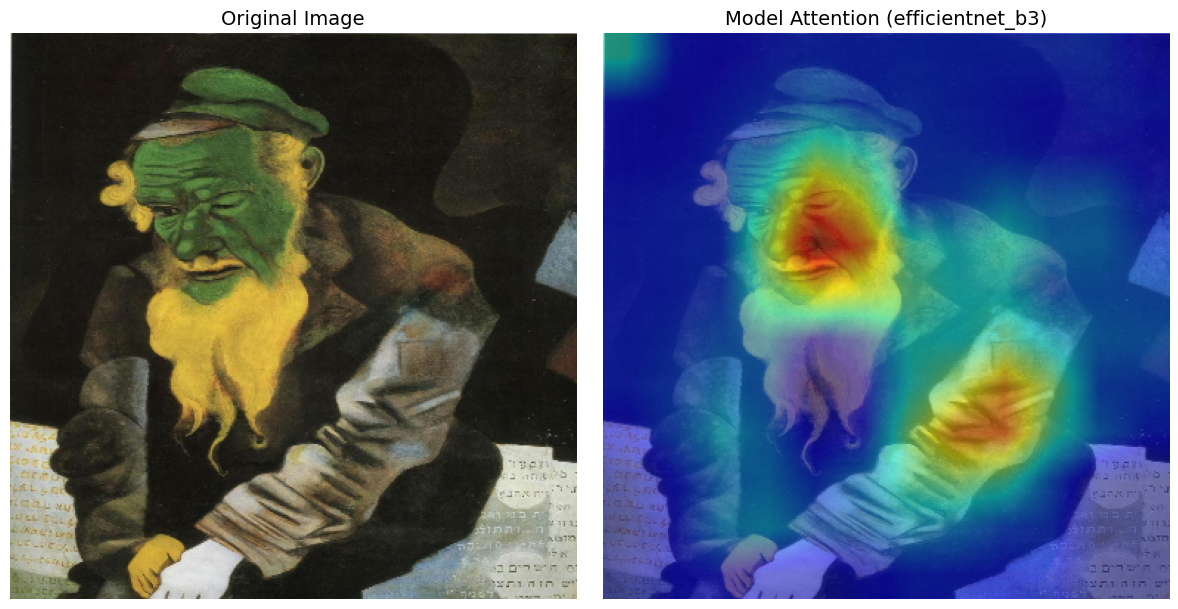

🤖 Prediction Class Index: 7
🔥 Confidence: 87.12%
🎨 Testing style: Impressionism
📂 File: octav-bancila_ig-ncu-cu-batic-ro-u-1915.jpg


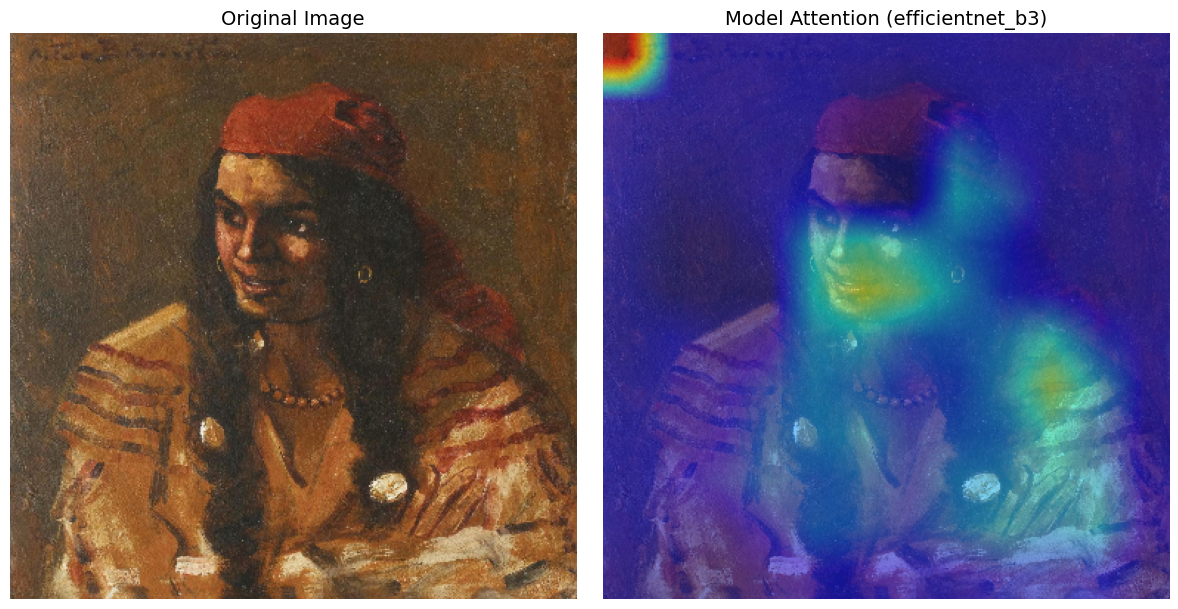

🤖 Prediction Class Index: 21
🔥 Confidence: 68.57%
🎨 Testing style: Pop_Art
📂 File: claes-oldenburg_floor-cone-1962.jpg


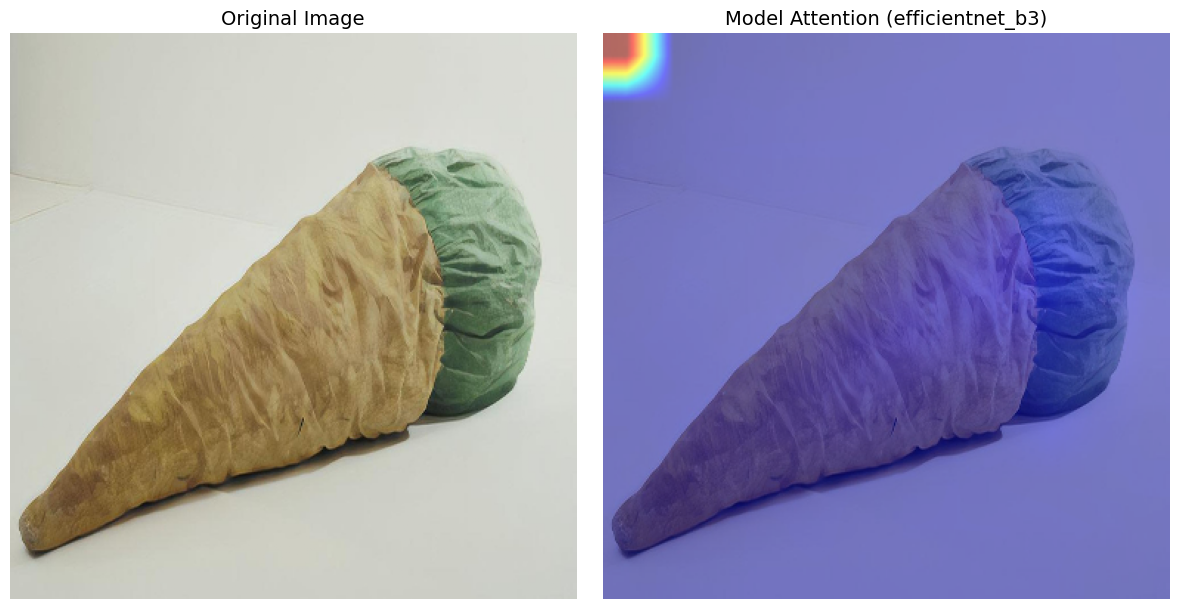

🤖 Prediction Class Index: 19
🔥 Confidence: 87.04%


In [4]:
import random
import glob

def test_random_image_from_style(style_name):
    style_dir = os.path.join(project_root, 'data', 'processed', style_name)
    
    if not os.path.exists(style_dir):
        print(f"❌ Style folder not found: {style_dir}")
        print("Available styles:", os.listdir(os.path.join(project_root, 'data', 'processed')))
        return
        
    images = glob.glob(os.path.join(style_dir, '*.jpg')) + glob.glob(os.path.join(style_dir, '*.png'))
    
    if len(images) > 0:
        random_img = random.choice(images)
        print(f"🎨 Testing style: {style_name}")
        print(f"📂 File: {os.path.basename(random_img)}")
        visualize_style_attention(random_img, model)
    else:
        print("No images found in folder.")

test_random_image_from_style('Cubism')
test_random_image_from_style('Impressionism')
test_random_image_from_style('Pop_Art')